In [1]:
import os
import tempfile

import anndata as ad
import muon
import numpy as np
import scanpy as sc
import seaborn as sns
import torch
import muon as mu
import pertpy as pt
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
from seaborn import clustermap
from lightning.pytorch import Trainer

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import scvi
print(scvi.__version__)


1.1.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
# Load the .h5ad file
adata = ad.read_h5ad('/Users/ismail/thesis/K562 essential RNA protein HVG.h5ad')

In [5]:
#adata.obs['batch'] = adata.obs['batch'].astype('category')
#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)

In [6]:
#adata.obs['batch'] = adata.obs['batch'].astype('category')

#sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch", subset=True)


In [7]:
#adata.write('/Users/ismail/thesis/K562 essential RNA protein HVG.h5ad')

In [8]:
adata.obs

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,sex,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,Female,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,Female,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,Female,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,Female,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,Female,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTGTCGTC-45,45,ATP6V1D,ENSG00000100554,P1P2,682_ATP6V1D_P1P2_ENSG00000100554,ATP6V1D_+_67826485.23-P1P2|ATP6V1D_+_67826497....,0.100272,18350.0,0.428227,1.115052,...,Female,53,ATP6V1D,human,CRISPR,cell_line,18044.0,4300,1,0.253547
TTTGTTGTCTGTCTCG-27,27,CNOT3,ENSG00000088038,P1P2,1718_CNOT3_P1P2_ENSG00000088038,CNOT3_+_54641532.23-P1P2|CNOT3_-_54641691.23-P1P2,0.093876,8671.0,-0.633593,0.813253,...,Female,53,CNOT3,human,CRISPR,cell_line,8510.0,3158,1,0.183196
TTTGTTGTCTGTGCGG-44,44,METTL3,ENSG00000165819,P1P2,5004_METTL3_P1P2_ENSG00000165819,METTL3_+_21979431.23-P1P2|METTL3_-_21979084.23...,0.107983,20568.0,1.054624,0.973352,...,Female,53,METTL3,human,CRISPR,cell_line,20355.0,4247,1,0.256595


In [9]:
adata.obs["nperts"].value_counts()

nperts
1    299694
0     10691
Name: count, dtype: int64

In [10]:
perturbations = [
    'ANAPC15', 'ARGLU1', 'ATF6B1B2', 'BCR', 'BUB1', 'BUB3', 'CADM4', 'CDC27', 'CDK1', 
    'CHMP6', 'CPSF3', 'CSE1L', 'DHX15', 'DNAJC19', 'DONSON', 'EGLN2', 'EIF2B5', 
    'EIF3A', 'EIF3H', 'EIF4E', 'EIF4G1', 'ESPN', 'FAM32A', 'GAB2', 'GNL2', 'GPS1', 
    'GTF2H1', 'HSPA5', 'HSPA9', 'ICE1', 'INTS2', 'KIF11', 'KPNB1', 'KRR1', 'KRT8', 
    'LSM2', 'LSM6', 'MED10', 'MED12', 'MED19', 'MZT1', 'NAA38', 'NACA', 'NCBP2', 
    'NLE1', 'NRDE2', 'NUF2', 'NUP98', 'NUP205', 'ORC1', 'PCF11', 'PHAX', 'PHB2', 
    'PMPCB', 'POLR2A', 'PPP2R1A', 'PRODH', 'PSMA3', 'PSMA4', 'PSMB7', 'PSMC2', 
    'PSMD4', 'PSMD6', 'PSMD7', 'PSMG3', 'PSTK', 'QARS', 'RARS', 'RPA1', 'RPA2P', 
    'RPL3', 'RPL8', 'RPL11', 'RPL23', 'RPL24', 'RPL30', 'RPL37', 'RPL37A', 'RPS12', 
    'RPS19', 'RPS29', 'RRM2', 'SF3B2', 'SF3B3', 'SLC1A5', 'SLC7A5', 'SLC39A9', 
    'SNRPG', 'SNX15', 'SON', 'SRSF11', 'SSR1', 'SUPT5H', 'TMEM23B', 'TPX2', 'TRAP', 
    'TSR2', 'WDH3', 'ZMAT2', 'NTC'
]

# Subset the AnnData object
perturbated_adata = adata[adata.obs["perturbation"].isin(perturbations)].copy()
control_adata = adata[adata.obs["nperts"] == 0].copy()


In [11]:
perturbated_adata.obs["nperts"].value_counts()

nperts
1    44371
Name: count, dtype: int64

In [12]:
combined_adata = ad.concat([perturbated_adata, control_adata])
adata_ref = combined_adata.copy()

In [13]:
QuasiSCVI.setup_anndata(adata_ref, batch_key="batch")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [14]:
# Initialize the Quasi SCVI model

scvi_ref = QuasiSCVI(
    adata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    b_prior_mixture= True,
    b_prior_mixture_k=5,
)

# Train the model
scvi_ref.train(max_epochs=200, plan_kwargs={"lr": 1e-4},accelerator='gpu')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/train/_trainrunner.py:70: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch operations are supported with this backend. Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 2/200:   0%|▎                                                     | 1/200 [00:14<46:34, 14.04s/it, v_num=1, train_loss_step=2.41e+3, train_loss_epoch=2.86e+3]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [15]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

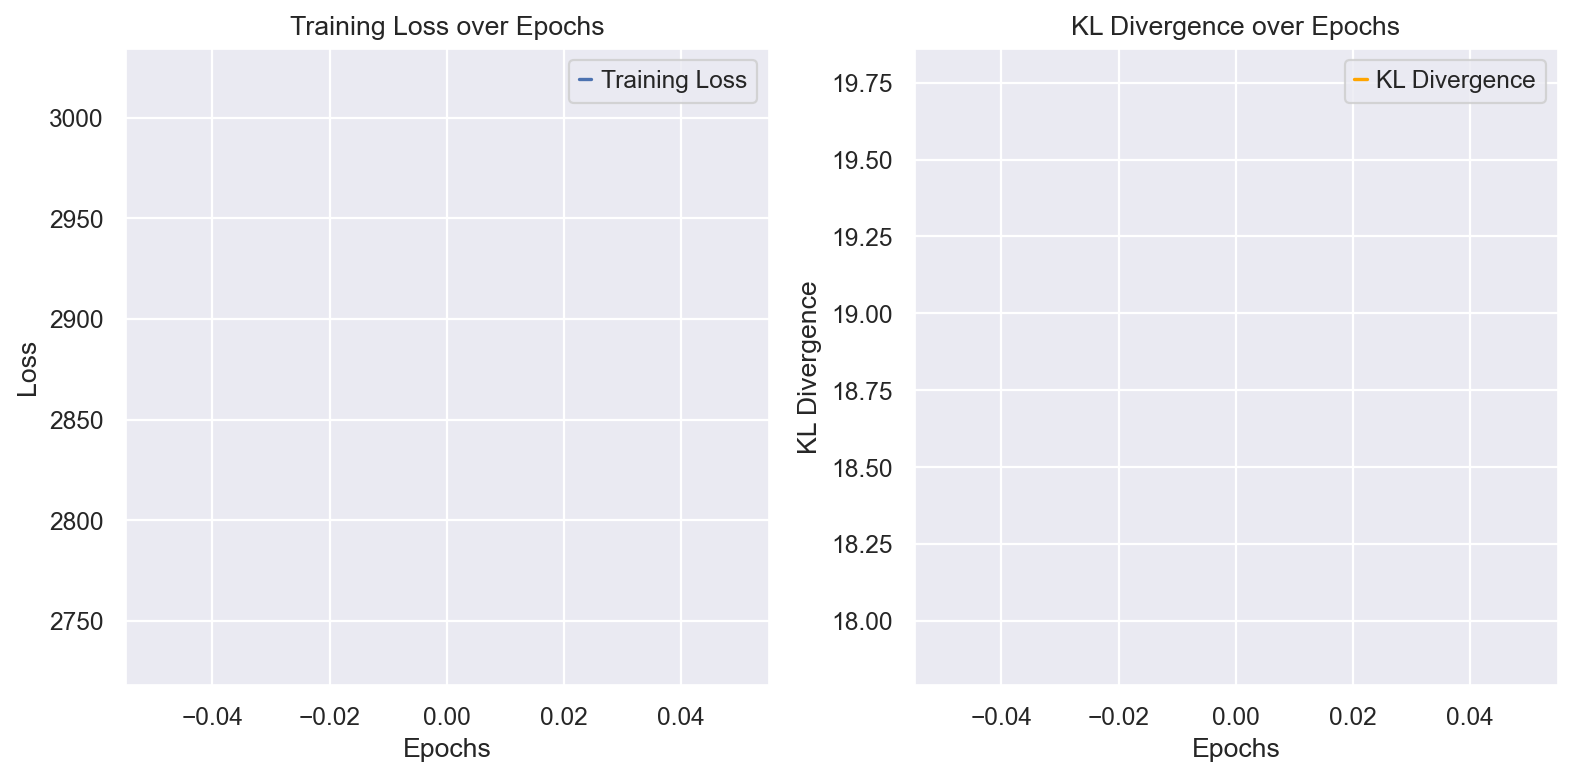

In [16]:
# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
SCVI_LATENT_KEY = "X_scVI"

adata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_29341/3423007261.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_ref)


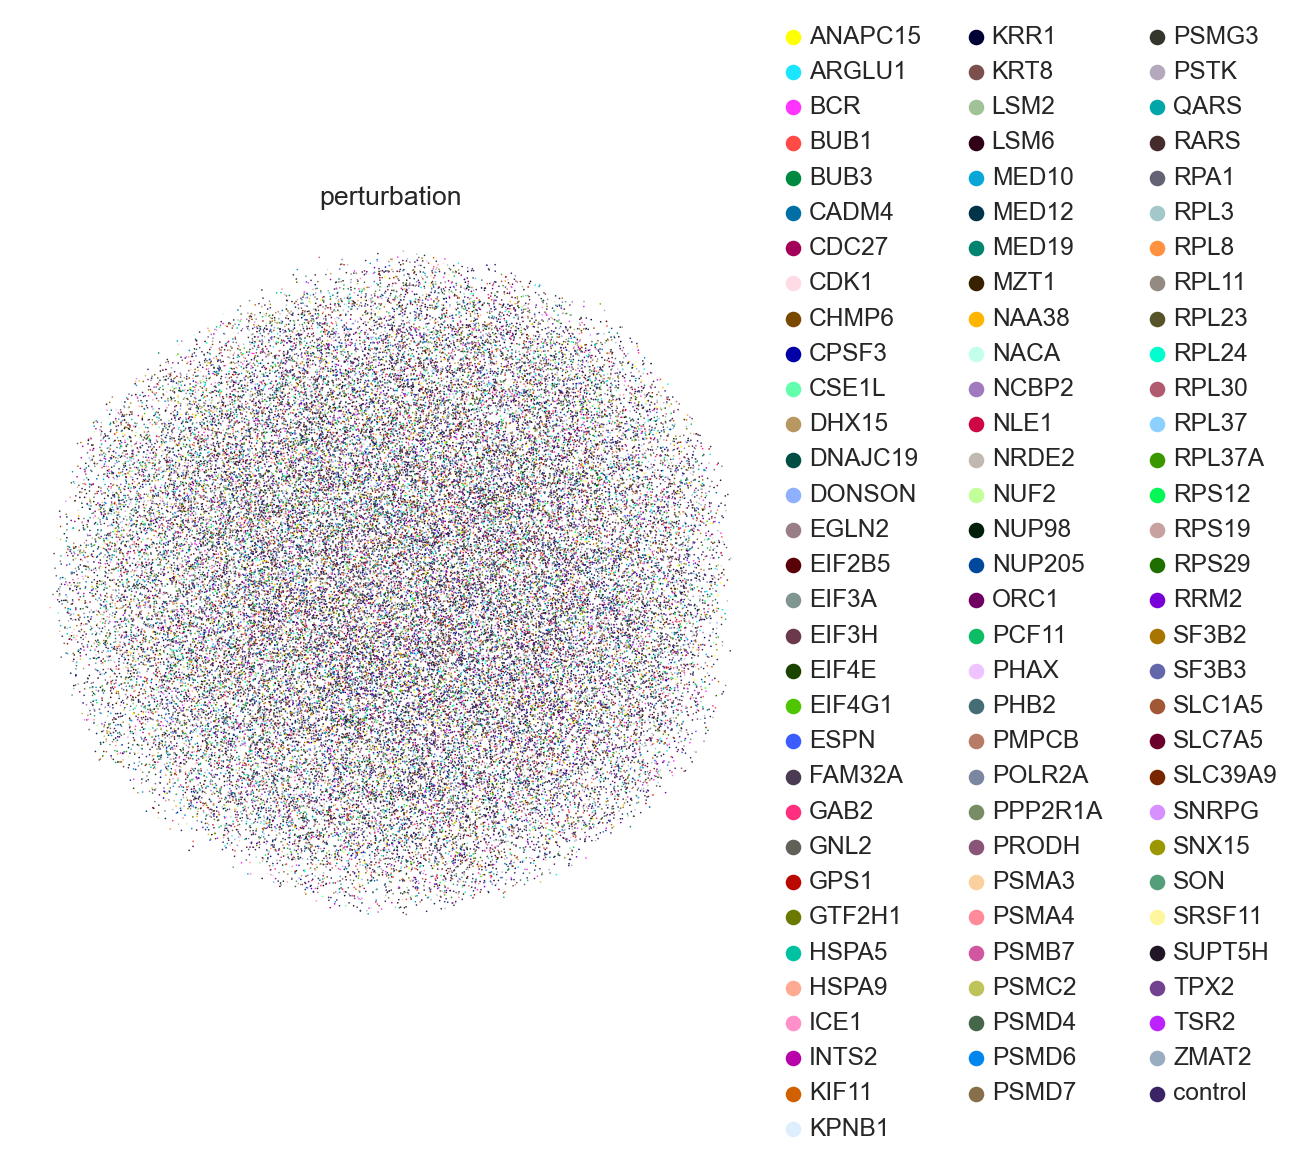

In [18]:
sc.pl.umap(
    adata_ref,
    color=[ "perturbation"],
    frameon=False,
    ncols=1,
)

In [ ]:
distance = pt.tl.Distance("edistance", obsm_key=SCVI_LATENT_KEY)
df = distance.pairwise(adata_ref, groupby="perturbation")

# Plot the clustermap
sns.clustermap(df, robust=True, figsize=(10, 10))
plt.show()

Working... ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3% -:--:--

In [ ]:

# Use the function to get the latent representation for b
latent_b = scvi_ref.get_b_latent_representation(adata_ref)

# Store the latent representation in the AnnData object
SCVI_LATENT_KEY_B = "X_scVI_b"
adata_ref.obsm[SCVI_LATENT_KEY_B] = latent_b

# Perform UMAP and clustering on the latent representation for b
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY_B)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

In [ ]:
sc.pl.umap(
    adata_ref,
    color=[ "perturbation"],
    frameon=False,
    ncols=1,
)